<a href="https://colab.research.google.com/github/shobhittya/deeplearning/blob/main/Deepfake_DenseNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

In [8]:
!pip install opendatasets --upgrade --quiet

In [11]:
import opendatasets as od

In [12]:
dataset_url = "https://www.kaggle.com/xhlulu/140k-real-and-fake-faces"

In [13]:
import os

In [14]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 3.75G/3.75G [01:10<00:00, 57.1MB/s]


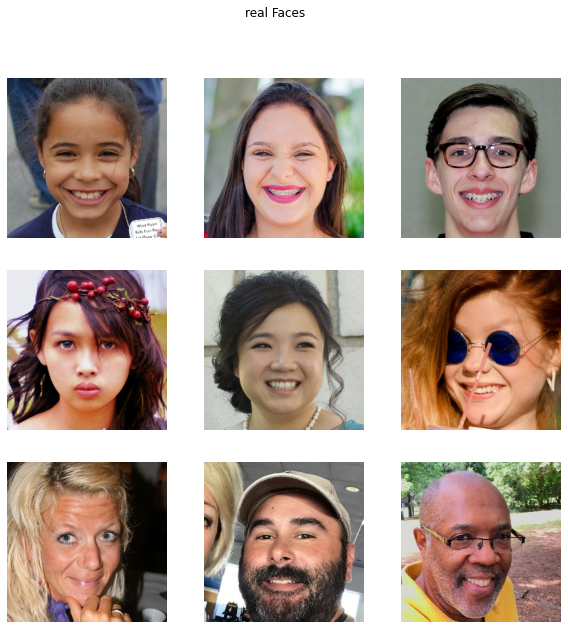

In [17]:
path = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(path, 'real').show()

**FAKE SET**

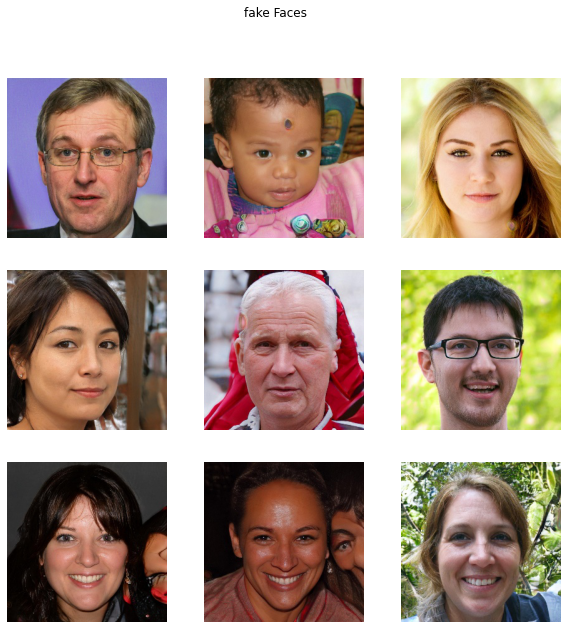

In [18]:
plot_img(path, 'fake').show()

**Train and Validation Set**

In [19]:
bs = 64
row, col = 224, 224
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
training_set = train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

**Model Architecture**

In [20]:
from tensorflow.keras.applications import DenseNet121
def get_model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(224,224,3)
                          )
    model = tf.keras.models.Sequential([densenet,
                                        GlobalAveragePooling2D(),
                                        Dense(512, activation='relu'),
                                        BatchNormalization(),
                                        Dropout(0.3),
                                        Dense(1, activation='sigmoid')
                                      ])
    model.compile(optimizer=Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

    return model

spoofnet = get_model()
spoofnet.summary()

29097984/29084464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 7,564,865
Trainable params: 7,480,193
Non-t

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**Defining Model Checkpoints**

In [22]:
checkpoint = ModelCheckpoint(filepath='spoffnet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

**Training model**

In [23]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

hist = spoofnet.fit(training_set,
                    validation_data=validation_set,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=4
                   )

Epoch 1/4
1562/1562 [==============================] - 2236s 1s/step - loss: 0.1710 - accuracy: 0.9305 - val_loss: 0.5011 - val_accuracy: 0.8222

Epoch 00001: val_loss improved from inf to 0.50105, saving model to spoffnet.h5
Epoch 2/4
1562/1562 [==============================] - 2184s 1s/step - loss: 0.0697 - accuracy: 0.9735 - val_loss: 0.1301 - val_accuracy: 0.9531

Epoch 00002: val_loss improved from 0.50105 to 0.13015, saving model to spoffnet.h5
Epoch 3/4
1562/1562 [==============================] - 2182s 1s/step - loss: 0.0531 - accuracy: 0.9803 - val_loss: 0.1733 - val_accuracy: 0.9325

Epoch 00003: val_loss did not improve from 0.13015
Epoch 4/4
1562/1562 [==============================] - 2179s 1s/step - loss: 0.0463 - accuracy: 0.9825 - val_loss: 0.0490 - val_accuracy: 0.9827

Epoch 00004: val_loss improved from 0.13015 to 0.04900, saving model to spoffnet.h5


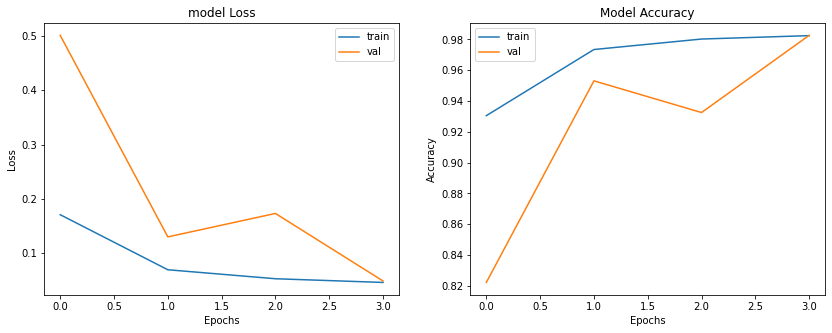

In [24]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

**Accuracy On Test Set**

In [25]:
_, accu = spoofnet.evaluate(test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

313/313 [==============================] - 115s 368ms/step - loss: 0.0466 - accuracy: 0.9822
Final Test Acccuracy = 98.220


**Confusion Matrix and Classification Report**

Confusion Matrix
[[5106 4894]
 [5062 4938]]
Classification Report
              precision    recall  f1-score   support

        fake       0.50      0.51      0.51     10000
        real       0.50      0.49      0.50     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



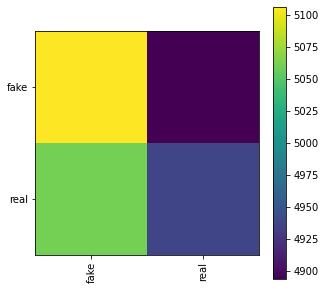

In [26]:
y_pred = spoofnet.predict(test_set)
y_pred = (y_pred < 0.5).astype(np.int)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm)

names = ['fake', 'real']
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=names))

plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.colorbar()
tick_mark = np.arange(len(names))
_ = plt.xticks(tick_mark, names, rotation=90)
_ = plt.yticks(tick_mark, names)
